In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [7]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet, load_point_clouds_from_filenames
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, \
encoder_with_convs_and_symmetry, decoder_with_fc_only

from tf_lab.in_out.basics import read_saved_epochs
from tf_lab.data_sets.articulated_human_poses import pc_loader
from tf_lab.point_clouds.convenience import reconstruct_pclouds
from tf_lab.data_sets.shape_net import snc_category_to_synth_id, load_all_point_clouds_under_folder

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
n_pc_points = 2048
do_training = True
first_time_running = True
seed = 42
class_name = 'chair'
ae_loss = 'chamfer'
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
syn_id = snc_category_to_synth_id()[class_name]

In [6]:
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
pclouds_path = osp.join(pclouds_path, syn_id)
pcloud_data = load_all_point_clouds_under_folder(pclouds_path)

In [9]:
# from language_and_3d.language_3d_io import  
from pc_completions.helper import load_pretrained_ae_from_iclr

# import 

In [11]:
ae = load_pretrained_ae_from_iclr(class_name='chair', loss=ae_loss, bneck=128, pc_type='uniform_one')
recon_pclouds, loss_val = reconstruct_pclouds(ae, pcloud_data.point_clouds, 100)
print 'Loss of reconstructed data ', loss_val

INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_2048_pts_128_bneck_chamfer/models.ckpt-500
Model restored in epoch 500.


In [17]:
from tf_lab.point_clouds.convenience import get_latent_codes
from general_tools.clustering.convenience import find_nearest_neighbors


latent_codes = get_latent_codes(ae, pcloud_data.point_clouds)

# _, latent_codes, temp_names = ae.embedding_at_tensor(pcloud_data, ae_conf, tensor_name='bottleneck')
# assert(np.alltrue(temp_names==pcloud_data.labels))
# model_ids = np.array([i.split('_')[1] for i in pcloud_data.labels], dtype=object)

In [37]:
# TODO symmetrize neighborhood structure 
n_neigbs = 3
nbrs, ndists = find_nearest_neighbors(latent_codes, k=n_neigbs)

In [42]:
n_shapes = pcloud_data.num_examples
src_pc = np.zeros(shape=(n_shapes * n_neigbs, n_pc_points, 3))
trg_pc = np.zeros(shape=(n_shapes * n_neigbs, n_pc_points, 3))

In [44]:
a = []
b = []
for i in range(n_neigbs):
    a.append(pcloud_data.point_clouds)
    b.append(pcloud_data.point_clouds[nbrs[:,i]])

In [50]:
A = np.vstack(a)
B = np.vstack(b)

(20334, 2048, 3)

20334

In [18]:
mixed_train_data = PointCloudDataSet(pcloud_data.point_clouds, noise=np.squeeze(pcloud_data.point_clouds[nbrs]))

In [11]:
encoder_args = { 'n_filters': [64, 128, 256, 128],
                 'filter_sizes': [20, 10, 5, 5],
                 'strides': [1, 1, 2, 2],
                 'b_norm': False,
                }

decoder_args = {'layer_sizes': [1024, 2048, n_pc_points*3], 'b_norm': False}

In [12]:
experiment_name =  'manifold_traverser_0'
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

conf = Conf(
            n_input = [n_pc_points, 3],
            loss = 'chamfer',
            training_epochs = 1000,
            batch_size = 50,
            denoising = True,
            learning_rate = 0.0005,
            train_dir = train_dir,              
            loss_display_step = 1,
            saver_step = 20,
            z_rotate = False,
            encoder = encoder_with_convs_and_symmetry,
            decoder = decoder_with_fc_only,
            encoder_args = encoder_args,
            decoder_args = decoder_args
           )    
conf.experiment_name = experiment_name
conf.save(osp.join(conf.train_dir, 'configuration'))

In [13]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

In [19]:
buf_size = 1 # flush each line
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(mixed_train_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.0961', 'loss=', '0.003988337')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/manifold_traverser_0/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.0934', 'loss=', '0.002401987')
('Epoch:', '0003', 'training time (minutes)=', '0.0940', 'loss=', '0.002145641')
('Epoch:', '0004', 'training time (minutes)=', '0.0938', 'loss=', '0.001952405')
('Epoch:', '0005', 'training time (minutes)=', '0.0948', 'loss=', '0.001814511')
('Epoch:', '0006', 'training time (minutes)=', '0.0962', 'loss=', '0.001742639')
('Epoch:', '0007', 'training time (minutes)=', '0.0961', 'loss=', '0.001666970')
('Epoch:', '0008', 'training time (minutes)=', '0.0972', 'loss=', '0.001603065')
('Epoch:', '0009', 'training time (minutes)=', '0.0980', 'loss=', '0.001548092')
('Epoch:', '0010', 'training time (minutes)=', '0.0972', 'loss=', '0.001515698')
('Epoch:'

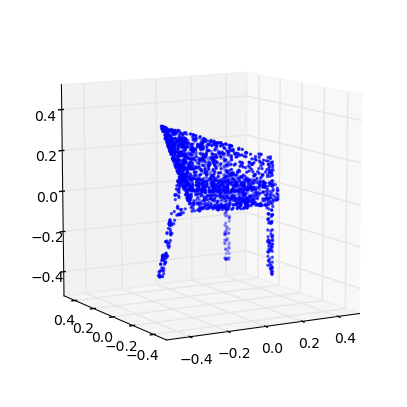

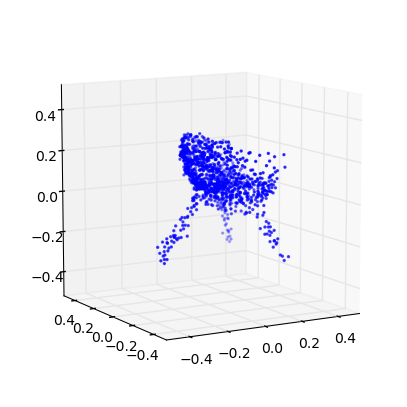

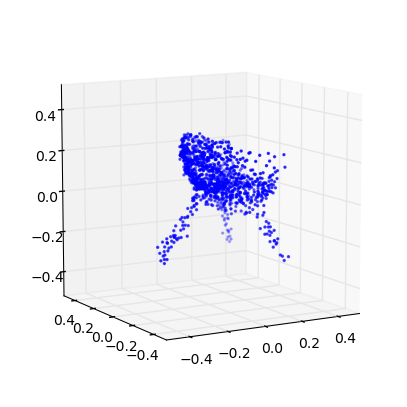

In [36]:
rid = np.random.randint(mixed_train_data.num_examples)
Point_Cloud(mixed_train_data.point_clouds[rid]).plot();
recon, _ = ae.reconstruct(np.expand_dims(mixed_train_data.point_clouds[rid],0), compute_loss=False)
Point_Cloud(recon[0]).plot()
# mixed_train_data.point_clouds[rid].shape